In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

# 2. Load Data

In [4]:
data = pd.read_csv('../Dataset/CreditCard.csv')
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 3. Initial Analysis

### 3.1. Metadata

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            int8   
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
dtypes: float64(5), int16(1), int8(3), object(2)
memory usage: 370.1+ MB


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [7]:
print(f'Columns Names - Unique Values - Columns Dtypes')
print(f'==============================================')
for idx, columns in enumerate(data.columns):
    print(f'{idx}. {columns} - {len(data[columns].unique())} - {data[columns].dtype}')

Columns Names - Unique Values - Columns Dtypes
0. step - 743 - int16
1. type - 5 - int8
2. amount - 5316900 - float64
3. nameOrig - 6353307 - object
4. oldbalanceOrg - 1845844 - float64
5. newbalanceOrig - 2682586 - float64
6. nameDest - 2722362 - object
7. oldbalanceDest - 3614697 - float64
8. newbalanceDest - 3555499 - float64
9. isFraud - 2 - int8
10. isFlaggedFraud - 2 - int8


### 3.2. Process Columns

In [5]:
data['type'] = data['type'].map({'CASH_IN' : 0,
                                'CASH_OUT' : 1,
                                'DEBIT' : 2,
                                'PAYMENT' : 3,
                                'TRANSFER' : 4,
                                })

In [6]:
def change_dtypes(data):
    data['step'] = data['step'].astype('int16')
    data['type'] = data['type'].astype('int8')
    data['isFraud'] = data['isFraud'].astype('int8')
    data['isFlaggedFraud'] = data['isFlaggedFraud'].astype('int8')
    return data

data = change_dtypes(data)

In [7]:
numerical_dtypes = ['int8', 'int16', 'int32', 'int64', 'float8', 'float16', 'float32', 'float64']

numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype in numerical_dtypes]
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object' or data[column_name].dtype == 'category']
print(f'Numerical Columns   :{numerical_columns}')
print(f'Categorical Columns :{categorical_columns}')

Numerical Columns   :['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Categorical Columns :['nameOrig', 'nameDest']


### 3.3. EDA

In [ ]:
num_cols = 2
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="is_Fraud", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col])\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Sex', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
plot_columns = numerical_columns[1:]

num_cols = 2
num_rows = math.ceil(len(plot_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(plot_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(plot_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

[Text(0, 0, '6.35441e+06'), Text(0, 0, '8213')]

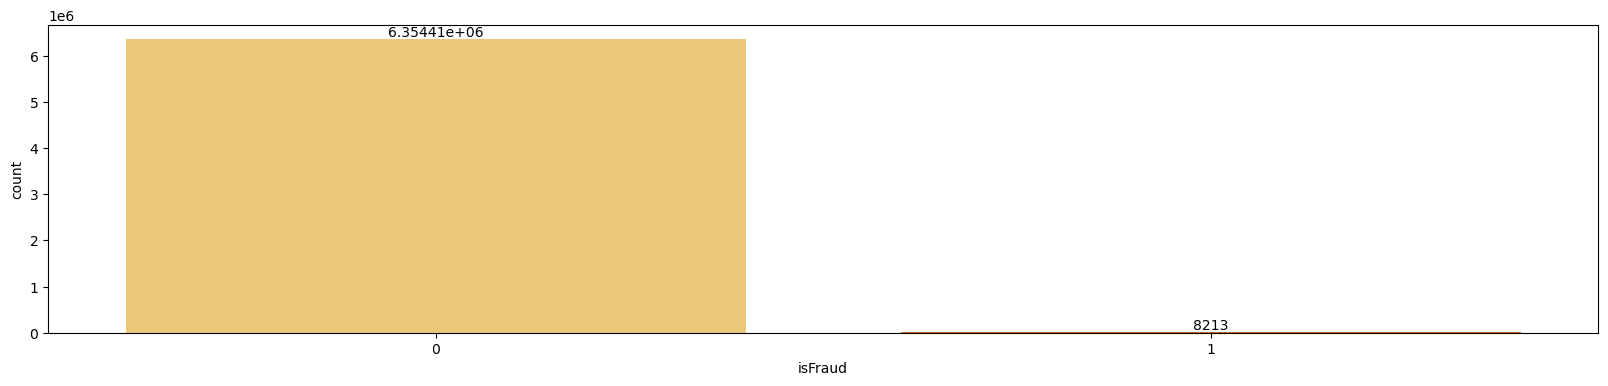

In [28]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'isFraud', palette='YlOrBr')
ax.bar_label(ax.containers[0])

### 3.4. Columns Correlations

Text(0.5, 1.0, 'Correlation Matrix')

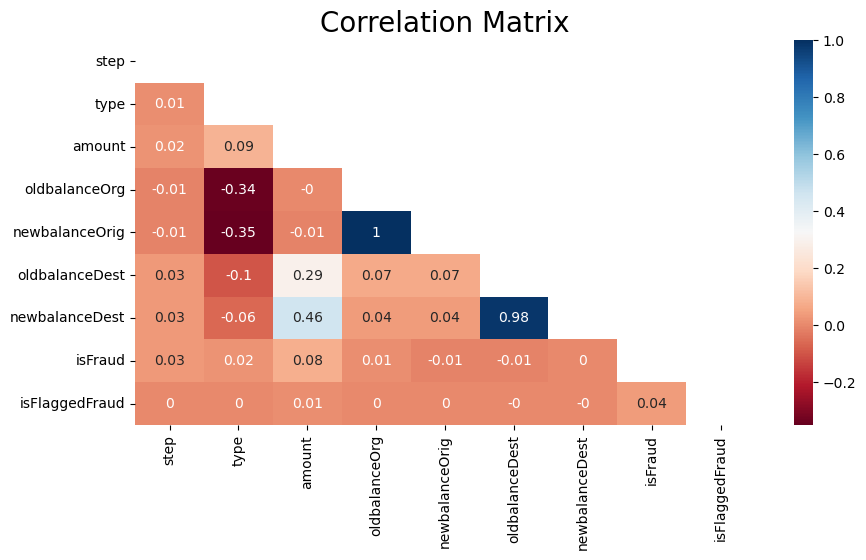

In [25]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Classification Algoritms

In [168]:
X = data.drop(columns=['isFraud', 'nameOrig', 'nameDest'])
Y = data['isFraud']

print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.9, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

Counter({0: 6354407, 1: 8213})
Counter({0: 8213, 1: 8213})
(14783, 8)
(1643, 8)


In [206]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier( n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    # ('adaboost', adaboost),
    ('bagging', bagging),
    # ('extraTress', extraTrees),
    # ('gradient', gradient),
    # ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    # ('knn', knn),
    # ('decisionTree', decisionTree),
], n_jobs=-1)

In [207]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [208]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 99.99 %
Test Score         : 99.51 %
R Squared Error    : 0.98
Mean Squared Error : 0.0


In [209]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

       Train Predictions  Actuals  Diff
13724                  1        1     0
12284                  1        1     0
1163                   0        0     0
6057                   0        0     0
6492                   0        0     0
8 / 1643


In [210]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       831
           1       1.00      0.99      1.00       812

    accuracy                           1.00      1643
   macro avg       1.00      1.00      1.00      1643
weighted avg       1.00      1.00      1.00      1643



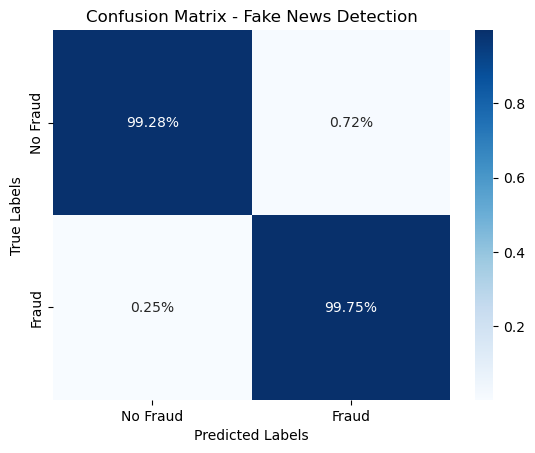

In [213]:
labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_test))
# Build confusion matrix
con_mat = confusion_matrix(y_test,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 5. Neural Network 

In [8]:
X = data.drop(columns=['isFraud', 'nameOrig', 'nameDest']).values
Y = data['isFraud']

print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = pd.get_dummies(Y).values

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_val = scalar.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

Counter({0: 6354407, 1: 8213})
(4466559, 8)
(1259799, 8)
(636262, 8)


In [9]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model


def LSTM_Model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model


def GRU_Model():
    model = Sequential()
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
    

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              9216      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 140,674
Trainable params: 140,674
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epoch = 1
batch_size = 512

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

8724/8724 [==============================] - 25s 3ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9996


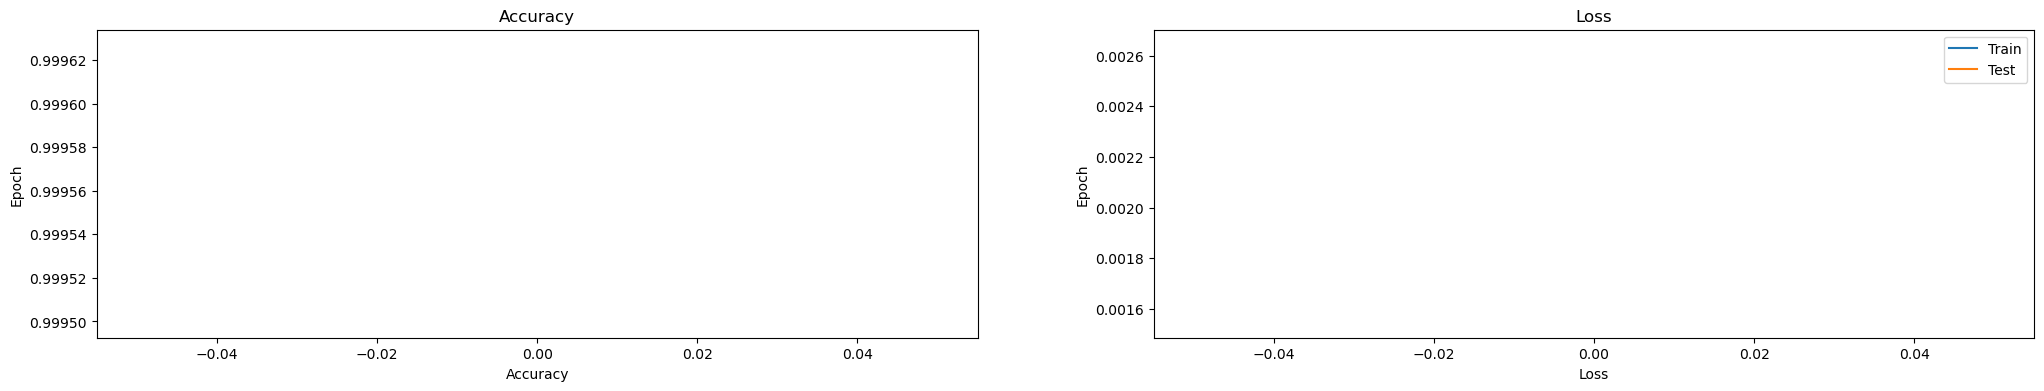

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [14]:
y_pred = np.rint(model.predict(X_test, verbose=0))

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1258162
           1       0.98      0.71      0.83      1637

   micro avg       1.00      1.00      1.00   1259799
   macro avg       0.99      0.86      0.91   1259799
weighted avg       1.00      1.00      1.00   1259799
 samples avg       1.00      1.00      1.00   1259799



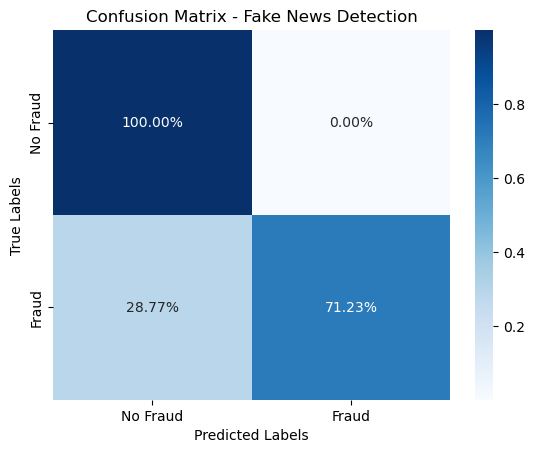

In [15]:
labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_test, verbose=0))
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()